In [5]:
pip install lime

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from lime import lime_tabular

# Define the dataset path and column names
data_path = "/content/updated_extended_echocardiogram.csv"  # Replace with the correct path
column_names = [
    "survival", "still_alive", "age_at_heart_attack", "pericardial_effusion",
    "fractional_shortening", "left_ventricular_end_diastolic", "wall_motion_score",
    "wall_motion_index", "mult", "alive_at_one", "ejection_fraction",
    "heart_rate", "systolic_bp", "diastolic_bp", "smoking_status",
    "cholesterol_level", "diabetes_status"
]

# Load the dataset with error handling
try:
    data = pd.read_csv(data_path, header=0, names=column_names, on_bad_lines="skip")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Check for rows that might cause issues and display the first few rows for verification
print("First few rows of the dataset:")
print(data.head())

# Remove invalid rows or columns with non-numeric data
print("Checking for non-numeric values...")
non_numeric_columns = data.select_dtypes(include=["object"]).columns
if not non_numeric_columns.empty:
    print(f"Non-numeric columns detected: {non_numeric_columns.tolist()}")
    print("Inspecting non-numeric values...")
    for col in non_numeric_columns:
        print(f"Unique values in {col}: {data[col].unique()}")

# Replace missing values ("?") with NaN, then drop rows with NaN
data = data.replace("?", np.nan)
data = data.dropna()

# Ensure all data is numeric
try:
    data = data.astype(float)
except ValueError as ve:
    print("Data contains non-numeric values that cannot be converted to float.")
    print(ve)
    exit()

# Separate features and target
X = data.drop(columns=["alive_at_one"])  # Features
y = data["alive_at_one"].astype(int)  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    class_names=["Not Alive", "Alive"],
    discretize_continuous=True,
    random_state=42
)

# Generate explanations for a single test instance
test_instance = X_test.iloc[0].values  # Select a test instance
exp = explainer.explain_instance(test_instance, rf_model.predict_proba, num_features=5)

# Display explanation in the notebook and save as HTML
exp.show_in_notebook(show_table=True)
exp.save_to_file("lime_explanation.html")  # Save explanation to an HTML file

# Save the cleaned data to a new file for inspection
cleaned_data_path = "cleaned_echocardiogram.csv"
data.to_csv(cleaned_data_path, index=False)
print(f"Cleaned data saved to: {cleaned_data_path}")

First few rows of the dataset:
   survival  still_alive  age_at_heart_attack  pericardial_effusion  \
0       0.0         71.0                  0.0                 0.260   
1       0.0         72.0                  0.0                 0.380   
2       0.0         55.0                  0.0                 0.260   
3       0.0         60.0                  0.0                 0.253   
4       1.0         57.0                  0.0                 0.160   

   fractional_shortening  left_ventricular_end_diastolic  wall_motion_score  \
0                  9.000                           4.600               14.0   
1                  6.000                           4.100               14.0   
2                  4.000                           3.420               14.0   
3                 12.062                           4.603               16.0   
4                 22.000                           5.750               18.0   

   wall_motion_index   mult  alive_at_one  ejection_fraction  heart

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Cleaned data saved to: cleaned_echocardiogram.csv


In [7]:
pip install eli5==0.11.0

In [8]:
pip install shap

In [9]:
pip install pandas numpy matplotlib scikit-learn

In [10]:
# Check data types
print("Data types:\n", X.dtypes)

Data types:
 survival                          float64
still_alive                       float64
age_at_heart_attack               float64
pericardial_effusion              float64
fractional_shortening             float64
left_ventricular_end_diastolic    float64
wall_motion_score                 float64
wall_motion_index                 float64
mult                              float64
ejection_fraction                 float64
heart_rate                        float64
systolic_bp                       float64
diastolic_bp                      float64
smoking_status                    float64
cholesterol_level                 float64
diabetes_status                   float64
dtype: object


#Post hoc explanation by SHAP

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# Load the dataset
data_path = "/content/updated_extended_echocardiogram.csv"
data = pd.read_csv(data_path)

# Define features and target
X = data.drop(columns=["alive_at_one"])
y = data["alive_at_one"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to keep feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Train Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print("Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Use feature importances from Random Forest directly
feature_importance = rf_model.feature_importances_
feature_names = X_test_scaled.columns

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()

# Print top features
print("\nTop 5 Most Important Features:")
print(importance_df.head().to_string())

# Additional analysis for top features
top_features = importance_df['Feature'].head().tolist()

print("\nDetailed Analysis of Top Features:")
for feature in top_features:
    print(f"\n{feature}:")
    print(f"Mean value: {X_test_scaled[feature].mean():.3f}")
    print(f"Std deviation: {X_test_scaled[feature].std():.3f}")

    # Calculate correlation with target for original (unbalanced) data
    correlation = data[feature].corr(data['alive_at_one'])
    print(f"Correlation with target: {correlation:.3f}")

# Save analysis results
with open('analysis_results.txt', 'w') as f:
    f.write("Model Performance Metrics:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred)}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred))
    f.write("\nFeature Importance Rankings:\n")
    f.write(importance_df.to_string())
    f.write("\n\nDetailed Feature Analysis:\n")
    for feature in top_features:
        f.write(f"\n{feature}:\n")
        f.write(f"Mean value: {X_test_scaled[feature].mean():.3f}\n")
        f.write(f"Std deviation: {X_test_scaled[feature].std():.3f}\n")
        correlation = data[feature].corr(data['alive_at_one'])
        f.write(f"Correlation with target: {correlation:.3f}\n")

print("\nAnalysis completed. Results saved to:")
print("1. feature_importance.png (Bar plot of feature importance)")
print("2. analysis_results.txt (Detailed analysis report)")

# Print suggestions for model improvement
print("\nSuggestions for Model Improvement:")
print("1. Consider feature selection based on importance scores")
print("2. Try gradient boosting algorithms (XGBoost, LightGBM)")
print("3. Experiment with different class weights or sampling techniques")
print("4. Investigate interaction effects between top features")

Model Performance:
Accuracy: 0.47745

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.44      0.54     13946
         1.0       0.30      0.56      0.39      6054

    accuracy                           0.48     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.58      0.48      0.50     20000


Top 5 Most Important Features:
                Feature  Importance
8                  mult    0.117705
2   age_at_heart_attack    0.114183
3  pericardial_effusion    0.107521
0              survival    0.095265
1           still_alive    0.079217

Detailed Analysis of Top Features:

mult:
Mean value: -0.014
Std deviation: 1.006
Correlation with target: -0.007

age_at_heart_attack:
Mean value: -0.011
Std deviation: 0.992
Correlation with target: -0.002

pericardial_effusion:
Mean value: -0.000
Std deviation: 1.003
Correlation with target: 0.003

survival:
Mean value: 0.003
Std deviation: 0.996
Correlatio

In [12]:
pip install scikit-survival survshap matplotlib

In [13]:
pip install scikit-survival

In [14]:
pip install lifelines

In [15]:
pip install -U scikit-survival

# Feature Selection BY SurvSHAP(t) method

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Load the dataset
data_path = "/content/updated_extended_echocardiogram.csv"
data = pd.read_csv(data_path)



In [17]:
data.columns

Index(['survival', 'still_alive', 'age_at_heart_attack',
       'pericardial_effusion', 'fractional_shortening',
       'left_ventricular_end_diastolic', 'wall_motion_score',
       'wall_motion_index', 'mult', 'alive_at_one', 'ejection_fraction',
       'heart_rate', 'systolic_bp', 'diastolic_bp', 'smoking_status',
       'cholesterol_level', 'diabetes_status'],
      dtype='object')

In [18]:
pip install lifelines shap scikit-survival pandas numpy

In [19]:
import pandas as pd
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
data_path = "/content/updated_extended_echocardiogram.csv"
data = pd.read_csv(data_path)

# Check the data
print(data.head())

# Prepare survival data
# 'survival' is the time-to-event, 'still_alive' is the event indicator (1 = alive, 0 = dead)
y = data[['survival', 'still_alive']]
y['still_alive'] = y['still_alive'].astype(bool)  # Convert to boolean for survival analysis
y = y.to_records(index=False)  # Convert to structured array for scikit-survival

# Features (exclude survival and event columns)
X = data.drop(columns=['survival', 'still_alive'])

# Encode categorical variables (if any)
X = OneHotEncoder().fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   survival  still_alive  age_at_heart_attack  pericardial_effusion  \
0       0.0         71.0                  0.0                 0.260   
1       0.0         72.0                  0.0                 0.380   
2       0.0         55.0                  0.0                 0.260   
3       0.0         60.0                  0.0                 0.253   
4       1.0         57.0                  0.0                 0.160   

   fractional_shortening  left_ventricular_end_diastolic  wall_motion_score  \
0                  9.000                           4.600               14.0   
1                  6.000                           4.100               14.0   
2                  4.000                           3.420               14.0   
3                 12.062                           4.603               16.0   
4                 22.000                           5.750               18.0   

   wall_motion_index   mult  alive_at_one  ejection_fraction  heart_rate  \
0               1.00  

<ipython-input-19-7be15b11879a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['still_alive'] = y['still_alive'].astype(bool)  # Convert to boolean for survival analysis


In [20]:
from lifelines import CoxPHFitter

# Combine features and survival data for lifelines
train_data = X_train.copy()
train_data['survival'] = y_train['survival']
train_data['still_alive'] = y_train['still_alive']

# Train the Cox model
cph = CoxPHFitter()
cph.fit(train_data, duration_col='survival', event_col='still_alive')

# Print model summary
cph.print_summary()

ImportError: Pandas requires version '3.1.2' or newer of 'jinja2' (version '3.0.3' currently installed).

<lifelines.CoxPHFitter: fitted with 80000 total observations, 0 right-censored observations>
             duration col = 'survival'
                event col = 'still_alive'
      baseline estimation = breslow
   number of observations = 80000
number of events observed = 80000
   partial log-likelihood = -823176.15
         time fit was run = 2025-01-19 21:50:01 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
age_at_heart_attack             0.03      1.03      0.01            0.00            0.05                1.00                1.05
pericardial_effusion            0.02      1.02      0.02           -0.02            0.06                0.98                1.06
fractional_shortening           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
left_ventricular_end_diastolic -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
wall_motion_score              -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
wall_motion_index              -0.02      0.98      0.01           -0.04           -0.01                0.96                0.99
mult                            0.04      1.04      0.02            0.00            0.08                1.00                1.08
alive_at_one                   -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
ejection_fraction               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
heart_rate                     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
systolic_bp                     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
diastolic_bp                   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
smoking_status                 -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
cholesterol_level               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
diabetes_status                -0.00      1.00      0.01           -0.02            0.01                0.98                1.01

                                cmp to     z    p  -log2(p)
covariate                                                  
age_at_heart_attack               0.00  2.11 0.03      4.84
pericardial_effusion              0.00  1.01 0.31      1.68
fractional_shortening             0.00  0.15 0.88      0.18
left_ventricular_end_diastolic    0.00 -0.20 0.84      0.25
wall_motion_score                 0.00 -2.61 0.01      6.78
wall_motion_index                 0.00 -2.74 0.01      7.34
mult                              0.00  2.09 0.04      4.76
alive_at_one                      0.00 -0.51 0.61      0.71
ejection_fraction                 0.00  0.11 0.91      0.13
heart_rate                        0.00 -0.19 0.85      0.24
systolic_bp                       0.00  0.38 0.70      0.51
diastolic_bp                      0.00 -0.25 0.80      0.32
smoking_status                    0.00 -0.33 0.74      0.43
cholesterol_level                 0.00  1.04 0.30      1.75
diabetes_status                   0.00 -0.32 0.75      0.42
---
Concordance = 0.50
Partial AIC = 1646382.30
log-likelihood ratio test = 25.93 on 15 df
-log2(p) of ll-ratio test = 4.69

PermutationExplainer explainer: 20001it [41:05,  8.09it/s]


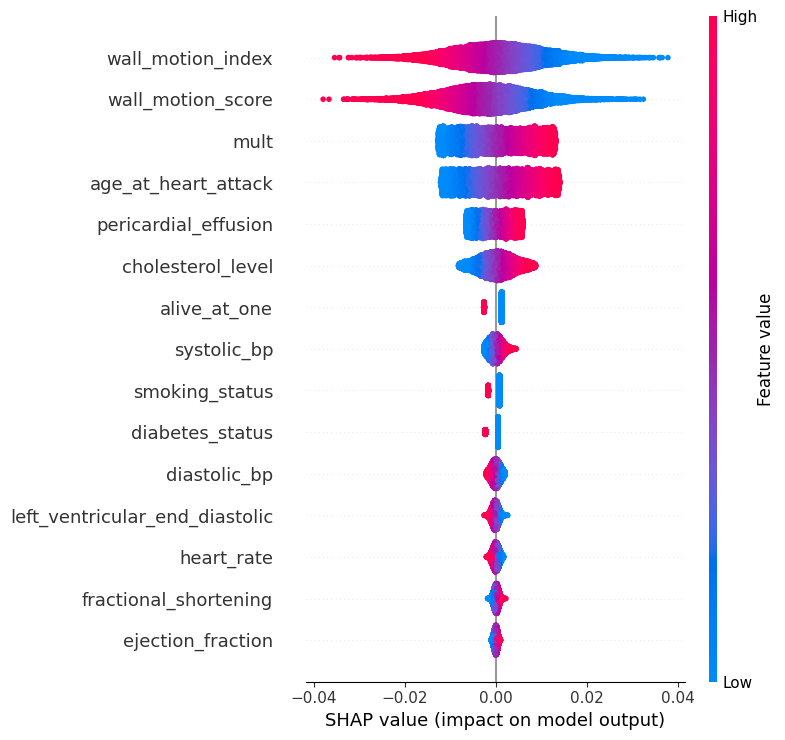

In [21]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(cph.predict_partial_hazard, X_train)
shap_values = explainer(X_test)

# Visualize SHAP values for a specific time point (e.g., t=365 days)
shap.summary_plot(shap_values.values, X_test, feature_names=X_train.columns)

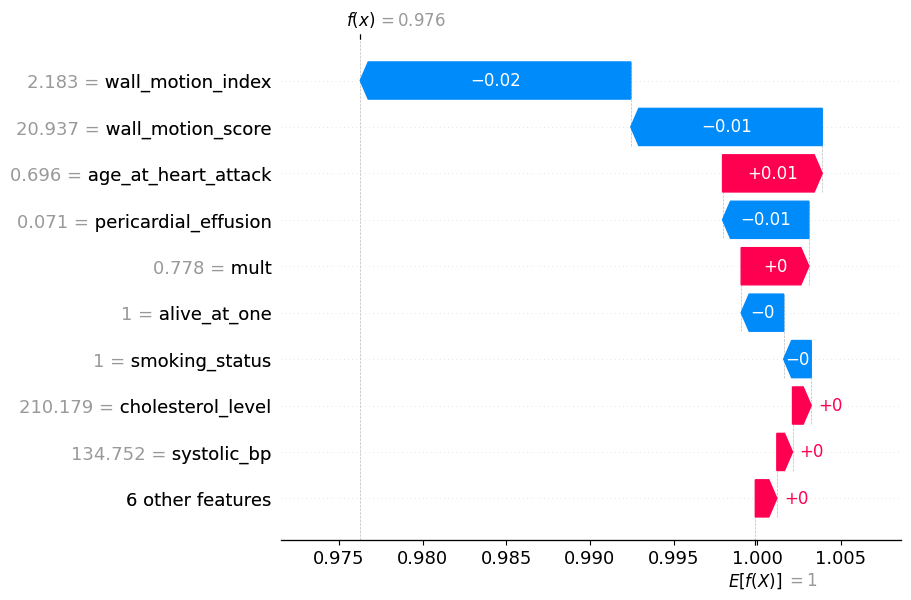

In [22]:
shap.plots.waterfall(shap_values[0])  # Example for the first sample

In [23]:
pip install "jinja2<3.1"

In [24]:
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

data_path = "/content/updated_extended_echocardiogram.csv"
data = pd.read_csv(data_path)

data.columns

Index(['survival', 'still_alive', 'age_at_heart_attack',
       'pericardial_effusion', 'fractional_shortening',
       'left_ventricular_end_diastolic', 'wall_motion_score',
       'wall_motion_index', 'mult', 'alive_at_one', 'ejection_fraction',
       'heart_rate', 'systolic_bp', 'diastolic_bp', 'smoking_status',
       'cholesterol_level', 'diabetes_status'],
      dtype='object')

In [25]:
import pandas as pd

# Load the dataset
data_path = "/content/updated_extended_echocardiogram.csv"
data = pd.read_csv(data_path)

# Check the data types of each column
print(data.dtypes)

survival                          float64
still_alive                       float64
age_at_heart_attack               float64
pericardial_effusion              float64
fractional_shortening             float64
left_ventricular_end_diastolic    float64
wall_motion_score                 float64
wall_motion_index                 float64
mult                              float64
alive_at_one                      float64
ejection_fraction                 float64
heart_rate                        float64
systolic_bp                       float64
diastolic_bp                      float64
smoking_status                      int64
cholesterol_level                 float64
diabetes_status                     int64
dtype: object


In [26]:
pip install pandas numpy scikit-survival eli5 shap

In [27]:
!pip show scikit-learn
!pip uninstall -y scikit-learn

Name: scikit-learn
Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

Copyright (c) 2007-2024 The scikit-learn developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS 

In [28]:
!pip uninstall scikit-learn scikit-survival -y

Found existing installation: scikit-survival 0.23.1
Uninstalling scikit-survival-0.23.1:
  Successfully uninstalled scikit-survival-0.23.1


In [29]:
!pip install numpy Cython
!apt-get install -y build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [31]:
!pip install numpy Cython

In [33]:
!pip uninstall -y scikit-learn scikit-survival

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
Found existing installation: scikit-survival 0.23.1
Uninstalling scikit-survival-0.23.1:
  Successfully uninstalled scikit-survival-0.23.1


In [36]:
pip install scikit-survival --user

In [37]:
pip show scikit-learn

Name: scikit-learn
Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

Copyright (c) 2007-2024 The scikit-learn developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS 

In [3]:
!pip uninstall -y scikit-learn scikit-survival

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
Found existing installation: scikit-survival 0.23.1
Uninstalling scikit-survival-0.23.1:
  Successfully uninstalled scikit-survival-0.23.1


In [4]:
!pip install "scikit-learn>=1.4,<1.6" scikit-survival==0.23.1

  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached scikit_survival-0.23.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (48 kB)
Using cached scikit_survival-0.23.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.9 MB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [3]:
print(data["event"].value_counts())

event
0    100000
Name: count, dtype: int64


In [4]:
print(data["still_alive"].value_counts())  # Check the distribution of the still_alive column

still_alive
60.000000    5
55.000000    4
62.000000    4
54.000000    4
59.000000    4
            ..
84.179718    1
60.415391    1
65.605247    1
51.611621    1
80.948444    1
Name: count, Length: 99966, dtype: int64


In [5]:
# Example: Threshold for determining 'event' based on still_alive
threshold = 60  # Adjust based on domain knowledge
data['event'] = data['still_alive'].apply(lambda x: 0 if x > threshold else 1)

# Check the distribution of the event column
print(data['event'].value_counts())

event
0    64939
1    35061
Name: count, dtype: int64


In [10]:
# Check for missing or invalid values in survival and event columns
print(data['survival'].isnull().sum())  # Should be 0
print(data['event'].value_counts())    # Should show 0 and 1 counts as above

0
event
0    64939
1    35061
Name: count, dtype: int64


In [2]:
import numpy as np

# Convert survival data into structured array
y = np.array([(bool(event), time) for event, time in zip(data['event'], data['survival'])],
             dtype=[('event', '?'), ('survival', '<f8')])

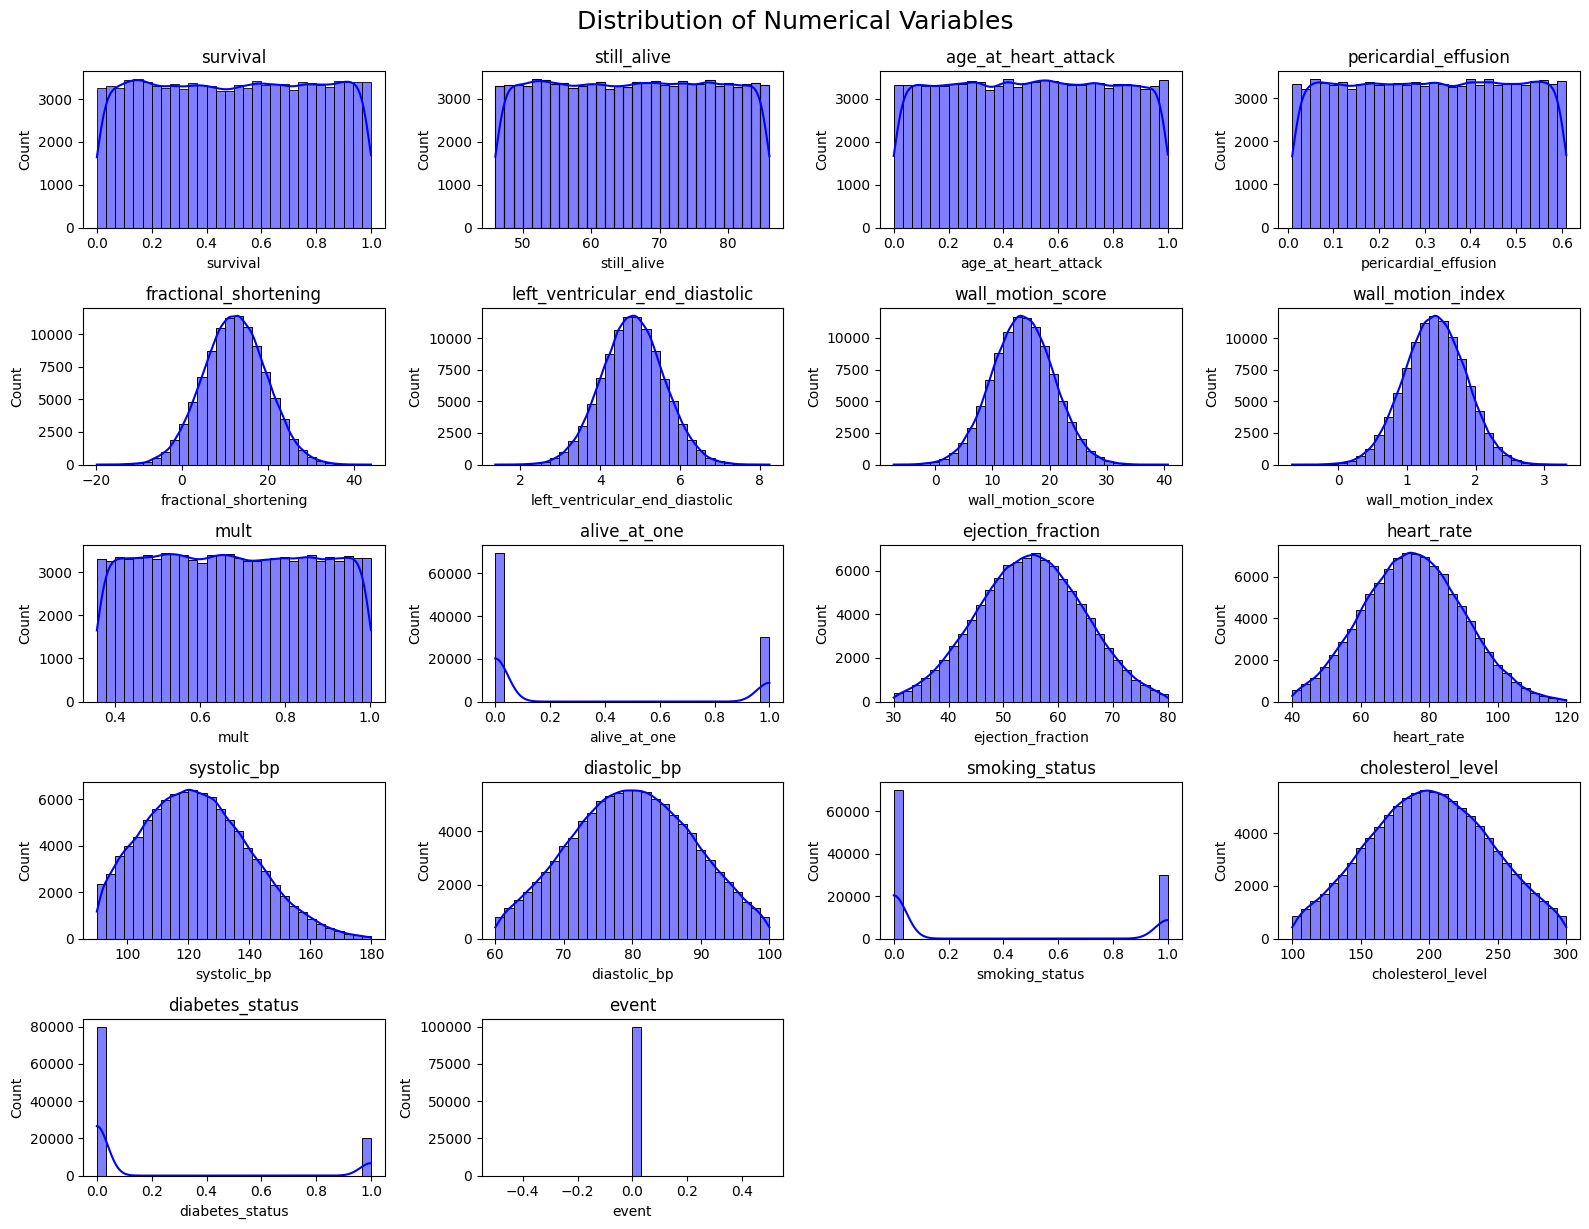

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns from the dataset
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Plot distributions for all numerical columns
plt.figure(figsize=(6, 4))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot((len(numerical_columns) + 3) // 4, 4, i)  # Adjust grid size
    sns.histplot(data[column], kde=True, bins=30, color='blue')
    plt.title(column)
    plt.tight_layout()

plt.suptitle('Distribution of Numerical Variables', fontsize=18, y=1.02)
plt.show()

In [5]:
# Identify categorical columns explicitly
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Alternatively, check for columns with a small number of unique values (e.g., less than 20)
# This assumes these columns may be categorical
potential_categorical_columns = [
    col for col in data.columns if data[col].nunique() < 20 and data[col].dtype != 'float64'
]

# Print the results
print("Explicitly categorical columns:", list(categorical_columns))
print("Potential categorical columns (based on unique values):", potential_categorical_columns)

Explicitly categorical columns: []
Potential categorical columns (based on unique values): ['smoking_status', 'diabetes_status', 'event']


<ipython-input-12-1dd4131e44e2>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


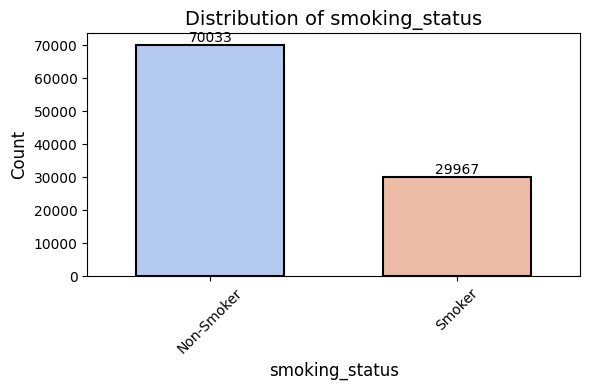

<ipython-input-12-1dd4131e44e2>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


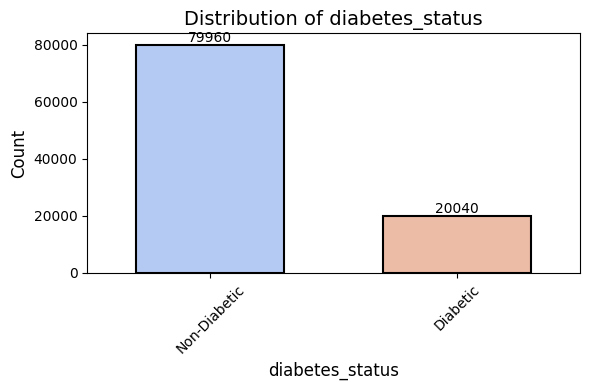

<ipython-input-12-1dd4131e44e2>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


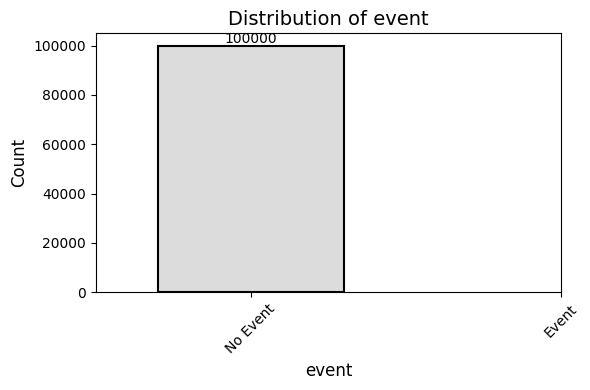

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the categorical columns and their mappings
categorical_columns = {
    'smoking_status': {0: 'Non-Smoker', 1: 'Smoker'},
    'diabetes_status': {0: 'Non-Diabetic', 1: 'Diabetic'},
    'event': {0: 'No Event', 1: 'Event'}
}

# Plot each categorical column's distribution
for col, mapping in categorical_columns.items():
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(
        data=data,
        x=col,
        palette='coolwarm',  # Change colour palette
        linewidth=1.5,       # Adjust border thickness
        edgecolor='black',   # Add black edges for better visibility
        width=0.6            # Set medium bar width
    )

    # Display values on each bar
    for patch in ax.patches:
        ax.annotate(
            f"{int(patch.get_height())}",  # Display the count
            (patch.get_x() + patch.get_width() / 2, patch.get_height()),  # Position
            ha='center', va='bottom', fontsize=10, color='black'  # Text alignment
        )

    # Update x-axis tick labels with the mapping
    ax.set_xticks(range(len(mapping)))  # Set ticks based on mapping
    ax.set_xticklabels([mapping[val] for val in sorted(mapping.keys())], fontsize=10)

    plt.title(f"Distribution of {col}", fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [5]:
# Load the data
file_path = "/content/updated_extended_echocardiogram.csv"
data = pd.read_csv(file_path)

data.columns

Index(['survival', 'still_alive', 'age_at_heart_attack',
       'pericardial_effusion', 'fractional_shortening',
       'left_ventricular_end_diastolic', 'wall_motion_score',
       'wall_motion_index', 'mult', 'alive_at_one', 'ejection_fraction',
       'heart_rate', 'systolic_bp', 'diastolic_bp', 'smoking_status',
       'cholesterol_level', 'diabetes_status'],
      dtype='object')

In [8]:
!pip install --no-cache-dir scikit-survival==0.23.1 "scikit-learn>=1.4,<1.6"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 276.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [12]:
!pip install mfp

In [14]:
import mfp
print(dir(mfp))

['__author__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'mfp_sub', 'utils']


In [16]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=f7b33b445abc8464d4130a47ac7c60143c4ead44f688a8a5ffc3dbfeecf33e4d
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [19]:
print(data.columns)

Index(['survival', 'still_alive', 'age_at_heart_attack',
       'pericardial_effusion', 'fractional_shortening',
       'left_ventricular_end_diastolic', 'wall_motion_score',
       'wall_motion_index', 'mult', 'alive_at_one', 'ejection_fraction',
       'heart_rate', 'systolic_bp', 'diastolic_bp', 'smoking_status',
       'cholesterol_level', 'diabetes_status', 'age_at_heart_attack_power_-2',
       'age_at_heart_attack_power_-1', 'age_at_heart_attack_power_-0.5',
       'age_at_heart_attack_power_0.5', 'age_at_heart_attack_power_1',
       'age_at_heart_attack_power_2', 'age_at_heart_attack_power_3',
       'ejection_fraction_power_-2', 'ejection_fraction_power_-1',
       'ejection_fraction_power_-0.5', 'ejection_fraction_power_0.5',
       'ejection_fraction_power_1', 'ejection_fraction_power_2',
       'ejection_fraction_power_3'],
      dtype='object')


#Multicollinearity analysis

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Calculate VIF for each feature
X = data.drop(columns=["survival", "still_alive"])  # Exclude survival and event columns
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display features with high VIF (>5 suggests high multicollinearity)
print(vif_data)

                           feature        VIF
0              age_at_heart_attack   3.975800
1             pericardial_effusion   4.167180
2            fractional_shortening   3.804773
3   left_ventricular_end_diastolic  34.482412
4                wall_motion_score   8.833889
5                wall_motion_index  10.507082
6                             mult  13.633427
7                     alive_at_one   1.433325
8                ejection_fraction  30.328516
9                       heart_rate  25.745365
10                     systolic_bp  41.972750
11                    diastolic_bp  60.690785
12                  smoking_status   1.425691
13               cholesterol_level  20.136847
14                 diabetes_status   1.249682


In [22]:
# Drop high VIF features iteratively
high_vif_features = [
    "diastolic_bp",  # Highest VIF
    "systolic_bp",
    "heart_rate",
    "left_ventricular_end_diastolic",
    "ejection_fraction",
    "cholesterol_level",
    "mult",
    "wall_motion_index",
    "wall_motion_score",
]

data_reduced = data.drop(columns=high_vif_features)

# Recalculate VIF
X_reduced = data_reduced.drop(columns=["survival", "still_alive"])  # Exclude survival-related columns
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data_reduced)

                 feature       VIF
0    age_at_heart_attack  2.942072
1   pericardial_effusion  3.006759
2  fractional_shortening  2.874998
3           alive_at_one  1.379416
4         smoking_status  1.372450
5        diabetes_status  1.224331


In [24]:
for col in ["age_at_heart_attack", "pericardial_effusion", "fractional_shortening",
            "alive_at_one", "smoking_status", "diabetes_status"]:
    print(data.groupby(col)["still_alive"].value_counts())

age_at_heart_attack  still_alive
0.000000             0              17
0.000023             0               1
0.000045             0               1
0.000052             0               1
0.000054             0               1
                                    ..
0.999925             0               1
0.999971             0               1
0.999973             0               1
0.999980             0               1
1.000000             0               5
Name: count, Length: 99940, dtype: int64
pericardial_effusion  still_alive
0.010000              0              1
0.010010              0              1
0.010012              0              1
0.010016              0              1
0.010021              0              1
                                    ..
0.609985              0              1
0.609988              0              1
0.609995              0              1
0.609996              0              1
0.609997              0              1
Name: count, Length: 99955, dtype:

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data[["age_at_heart_attack", "pericardial_effusion", "fractional_shortening",
          "alive_at_one", "smoking_status", "diabetes_status"]]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                 Feature       VIF
0    age_at_heart_attack  2.942072
1   pericardial_effusion  3.006759
2  fractional_shortening  2.874998
3           alive_at_one  1.379416
4         smoking_status  1.372450
5        diabetes_status  1.224331


In [26]:
print(data["still_alive"].value_counts())

still_alive
0    99960
Name: count, dtype: int64


In [28]:
data.loc[data.sample(frac=0.01, random_state=42).index, "still_alive"] = 1

In [29]:
from lifelines import CoxPHFitter

# Fit the Cox model with the reduced dataset
cph = CoxPHFitter()
cph.fit(data[["age_at_heart_attack", "pericardial_effusion", "fractional_shortening",
              "alive_at_one", "smoking_status", "diabetes_status", "survival", "still_alive"]],
        duration_col="survival", event_col="still_alive")

# Print the summary of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 99960 total observations, 98960 right-censored observations>
             duration col = 'survival'
                event col = 'still_alive'
      baseline estimation = breslow
   number of observations = 99960
number of events observed = 1000
   partial log-likelihood = -10521.67
         time fit was run = 2025-01-20 04:56:20 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
age_at_heart_attack    0.35      1.42      0.11            0.14            0.57                1.14                1.76
pericardial_effusion  -0.04      0.97      0.18           -0.39            0.32                0.68                1.38
fractional_shortening -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
alive_at_one           0.04      1.04      0.07           -0.09            0.18                0.91                1.19
smoking_status        -0.07      0.93      0.07           -0.21            0.07                0.81                1.07
diabetes_status       -0.24      0.79      0.08           -0.40           -0.07                0.67                0.93

                       cmp to     z      p  -log2(p)
covariate                                           
age_at_heart_attack      0.00  3.19 <0.005      9.46
pericardial_effusion     0.00 -0.19   0.85      0.24
fractional_shortening    0.00 -1.39   0.16      2.62
alive_at_one             0.00  0.60   0.55      0.87
smoking_status           0.00 -0.99   0.32      1.64
diabetes_status          0.00 -2.79   0.01      7.58
---
Concordance = 0.54
Partial AIC = 21055.35
log-likelihood ratio test = 21.57 on 6 df
-log2(p) of ll-ratio test = 9.43

In [33]:
from lifelines.statistics import proportional_hazard_test

# Run the test
test_results = proportional_hazard_test(cph, data, time_transform="rank")
print(test_results)

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 99960 total observations, 98960 right-censored observations>
         test_name = proportional_hazard_test

---
                                test_statistic      p  -log2(p)
age_at_heart_attack                      87.10 <0.005     66.39
age_timedep                              13.76 <0.005     12.24
alive_at_one                              0.14   0.71      0.49
cholesterol_level                         0.25   0.62      0.69
diabetes_status                           0.08   0.78      0.36
diastolic_bp                              0.85   0.36      1.49
ejection_fraction                         1.61   0.20      2.29
fractional_shortening                     0.36   0.55      0.86
heart_rate                                0.34   0.56      0.84
left_ventricular_end_diastolic            0.01   0.94

In [31]:
data["age_timedep"] = data["age_at_heart_attack"] * data["survival"]
cph.fit(data, duration_col="survival", event_col="still_alive")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 99960 total observations, 98960 right-censored observations>
             duration col = 'survival'
                event col = 'still_alive'
      baseline estimation = breslow
   number of observations = 99960
number of events observed = 1000
   partial log-likelihood = -9829.82
         time fit was run = 2025-01-20 05:02:53 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
age_at_heart_attack              7.64   2080.19      0.24            7.17            8.11             1294.58             3342.53
pericardial_effusion            -0.05      0.95      0.18           -0.41            0.31                0.67                1.36
fractional_shortening           -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
left_ventricular_end_diastolic   0.03      1.03      0.04           -0.05            0.11                0.95                1.12
wall_motion_score                0.00      1.00      0.01           -0.01            0.02                0.99                1.02
wall_motion_index                0.11      1.11      0.07           -0.03            0.25                0.97                1.28
mult                             0.10      1.11      0.17           -0.23            0.44                0.79                1.55
alive_at_one                     0.04      1.04      0.07           -0.10            0.17                0.91                1.19
ejection_fraction               -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
heart_rate                      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
systolic_bp                     -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
diastolic_bp                    -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
smoking_status                  -0.07      0.93      0.07           -0.21            0.07                0.81                1.07
cholesterol_level                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
diabetes_status                 -0.23      0.79      0.09           -0.40           -0.07                0.67                0.94
age_timedep                    -11.36      0.00      0.35          -12.06          -10.67                0.00                0.00

                                cmp to      z      p  -log2(p)
covariate                                                     
age_at_heart_attack               0.00  31.57 <0.005    724.43
pericardial_effusion              0.00  -0.27   0.79      0.34
fractional_shortening             0.00  -1.28   0.20      2.33
left_ventricular_end_diastolic    0.00   0.75   0.45      1.14
wall_motion_score                 0.00   0.70   0.48      1.05
wall_motion_index                 0.00   1.53   0.13      2.98
mult                              0.00   0.60   0.55      0.87
alive_at_one                      0.00   0.54   0.59      0.76
ejection_fraction                 0.00  -0.41   0.68      0.55
heart_rate                        0.00  -1.15   0.25      2.00
systolic_bp                       0.00  -0.80   0.42      1.24
diastolic_bp                      0.00  -0.51   0.61      0.72
smoking_status                    0.00  -0.98   0.32      1.62
cholesterol_level                 0.00   0.90   0.37      1.44
diabetes_status                   0.00  -2.73   0.01      7.32
age_timedep                       0.00 -32.03 <0.005    745.40
---
Concordance = 0.86
Partial AIC = 19691.65
log-likelihood ratio test = 1405.28 on 16 df
-log2(p) of ll-ratio test = 959.78

In [35]:
# Add time-dependent interaction term
data["age_timedep"] = data["age_at_heart_attack"] * data["survival"]

# Refit the model
cph.fit(data, duration_col="survival", event_col="still_alive")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 99960 total observations, 98960 right-censored observations>
             duration col = 'survival'
                event col = 'still_alive'
      baseline estimation = breslow
   number of observations = 99960
number of events observed = 1000
   partial log-likelihood = -9829.82
         time fit was run = 2025-01-20 05:08:09 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
age_at_heart_attack              7.64   2080.19      0.24            7.17            8.11             1294.58             3342.53
pericardial_effusion            -0.05      0.95      0.18           -0.41            0.31                0.67                1.36
fractional_shortening           -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
left_ventricular_end_diastolic   0.03      1.03      0.04           -0.05            0.11                0.95                1.12
wall_motion_score                0.00      1.00      0.01           -0.01            0.02                0.99                1.02
wall_motion_index                0.11      1.11      0.07           -0.03            0.25                0.97                1.28
mult                             0.10      1.11      0.17           -0.23            0.44                0.79                1.55
alive_at_one                     0.04      1.04      0.07           -0.10            0.17                0.91                1.19
ejection_fraction               -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
heart_rate                      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
systolic_bp                     -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
diastolic_bp                    -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
smoking_status                  -0.07      0.93      0.07           -0.21            0.07                0.81                1.07
cholesterol_level                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
diabetes_status                 -0.23      0.79      0.09           -0.40           -0.07                0.67                0.94
age_timedep                    -11.36      0.00      0.35          -12.06          -10.67                0.00                0.00

                                cmp to      z      p  -log2(p)
covariate                                                     
age_at_heart_attack               0.00  31.57 <0.005    724.43
pericardial_effusion              0.00  -0.27   0.79      0.34
fractional_shortening             0.00  -1.28   0.20      2.33
left_ventricular_end_diastolic    0.00   0.75   0.45      1.14
wall_motion_score                 0.00   0.70   0.48      1.05
wall_motion_index                 0.00   1.53   0.13      2.98
mult                              0.00   0.60   0.55      0.87
alive_at_one                      0.00   0.54   0.59      0.76
ejection_fraction                 0.00  -0.41   0.68      0.55
heart_rate                        0.00  -1.15   0.25      2.00
systolic_bp                       0.00  -0.80   0.42      1.24
diastolic_bp                      0.00  -0.51   0.61      0.72
smoking_status                    0.00  -0.98   0.32      1.62
cholesterol_level                 0.00   0.90   0.37      1.44
diabetes_status                   0.00  -2.73   0.01      7.32
age_timedep                       0.00 -32.03 <0.005    745.40
---
Concordance = 0.86
Partial AIC = 19691.65
log-likelihood ratio test = 1405.28 on 16 df
-log2(p) of ll-ratio test = 959.78

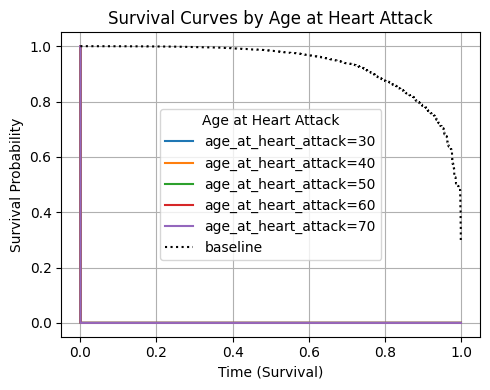

In [40]:
import matplotlib.pyplot as plt

# Plot survival curves for different age groups
cph.plot_covariate_groups('age_at_heart_attack', values=[30, 40, 50, 60, 70])

# Customise the plot
plt.title('Survival Curves by Age at Heart Attack')
plt.xlabel('Time (Survival)')
plt.ylabel('Survival Probability')
plt.legend(title='Age at Heart Attack')
plt.grid(True)
fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.tight_layout()
plt.show()

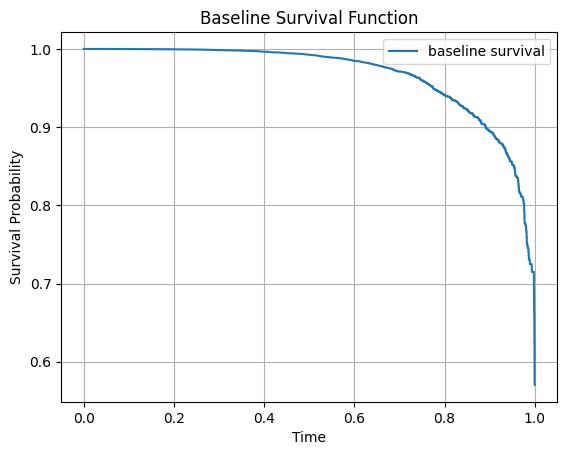

In [41]:
# Plot baseline survival function
baseline_survival = cph.baseline_survival_
baseline_survival.plot()
plt.title('Baseline Survival Function')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 99960 total observations, 98960 right-censored observations>
         test_name = proportional_hazard_test

---
                                     test_statistic      p  -log2(p)
age_at_heart_attack            km              6.19   0.01      6.29
                               rank           87.10 <0.005     66.39
age_timedep                    km             96.67 <0.005     73.37
                               rank           13.76 <0.005     12.24
alive_at_one                   km              0.06   0.80      0.31
                               rank            0.14   0.71      0.49
cholesterol_level              km              0.17   0.68      0.55
                               rank            0.25   0.62      0.69
diabetes_status                km              0.18   0.67      0.58
                               rank            0.08   0.78      0.36
diastolic_bp                   km              2.01   0.16      2.68
                               rank            0.85   0.36      1.49
ejection_fraction              km              3.94   0.05      4.41
                               rank            1.61   0.20      2.29
fractional_shortening          km              0.01   0.93      0.10
                               rank            0.36   0.55      0.86
heart_rate                     km              0.34   0.56      0.84
                               rank            0.34   0.56      0.84
left_ventricular_end_diastolic km              0.60   0.44      1.19
                               rank            0.01   0.94      0.10
mult                           km              2.70   0.10      3.31
                               rank            5.36   0.02      5.60
pericardial_effusion           km              0.37   0.54      0.89
                               rank            0.55   0.46      1.12
smoking_status                 km              0.04   0.85      0.24
                               rank            0.00   0.99      0.01
systolic_bp                    km              0.02   0.88      0.18
                               rank            0.11   0.74      0.44
wall_motion_index              km              0.90   0.34      1.54
                               rank            0.39   0.53      0.91
wall_motion_score              km              2.34   0.13      2.99
                               rank            1.58   0.21      2.26



1. Variable 'age_at_heart_attack' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'age_at_heart_attack' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age_at_heart_attack' using pd.cut, and then specify it in
`strata=['age_at_heart_attack', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take 

[[<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0128)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4595)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5414)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5503)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9321)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9359)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4380)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2086)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1262)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5334)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3440)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0206)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1005)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7121)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8045)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2049)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0471)'>],
 [<Axes: xlabel='rank-transformed tim

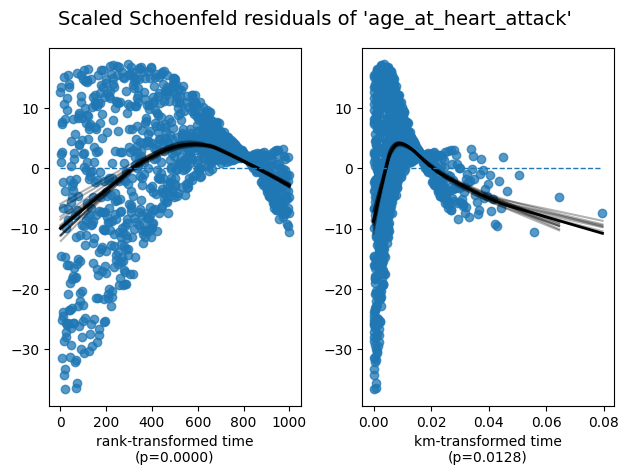

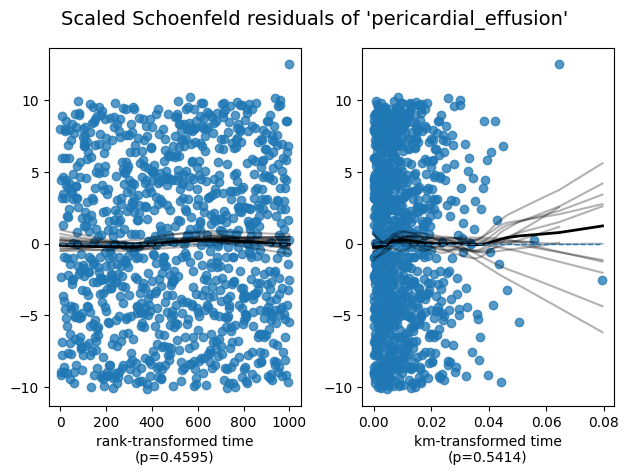

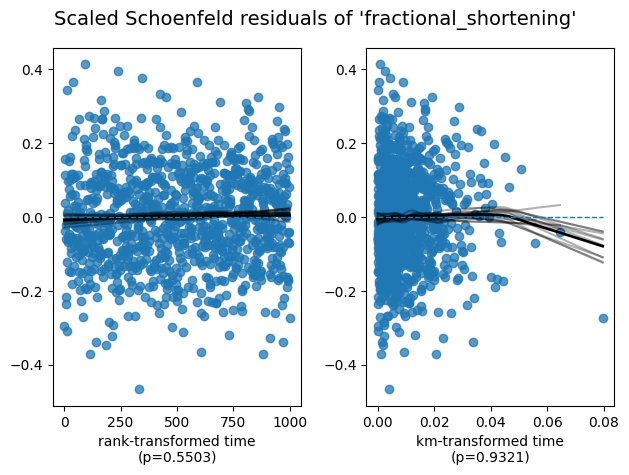

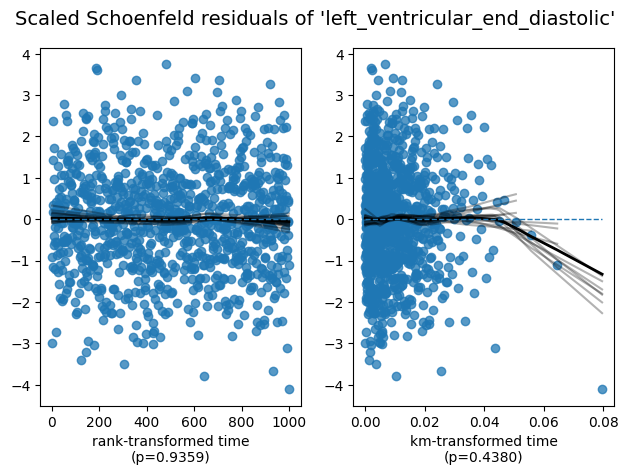

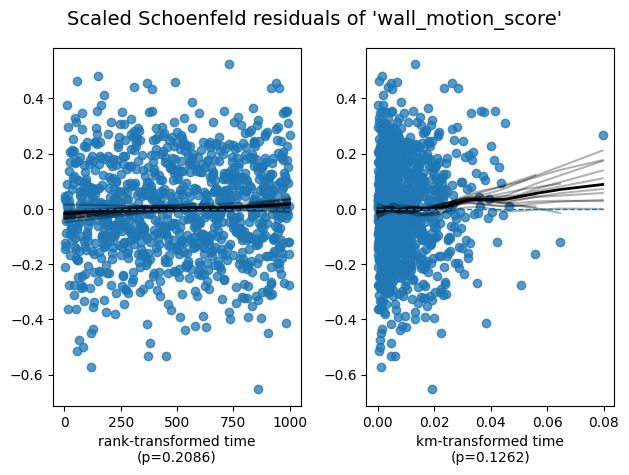

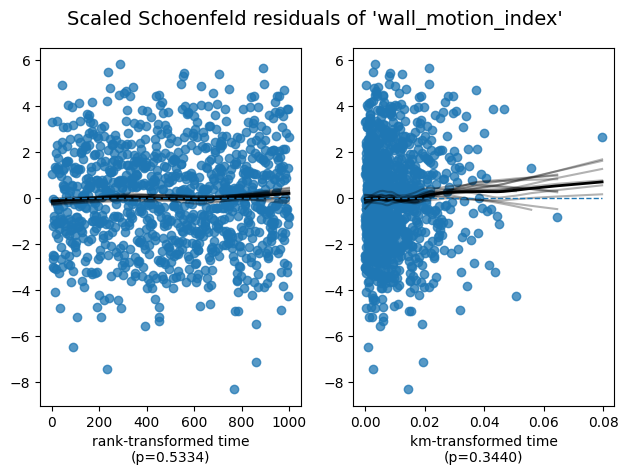

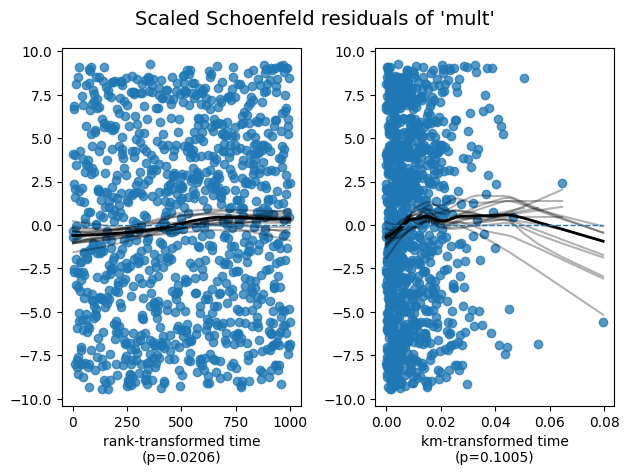

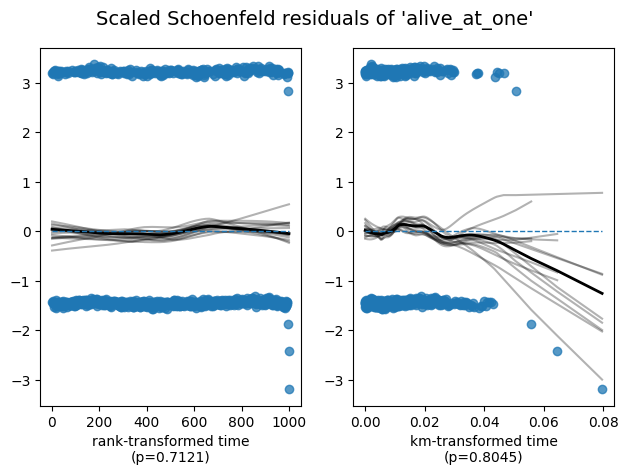

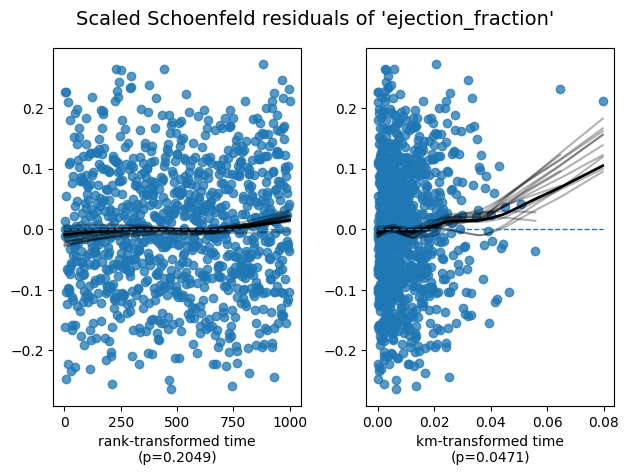

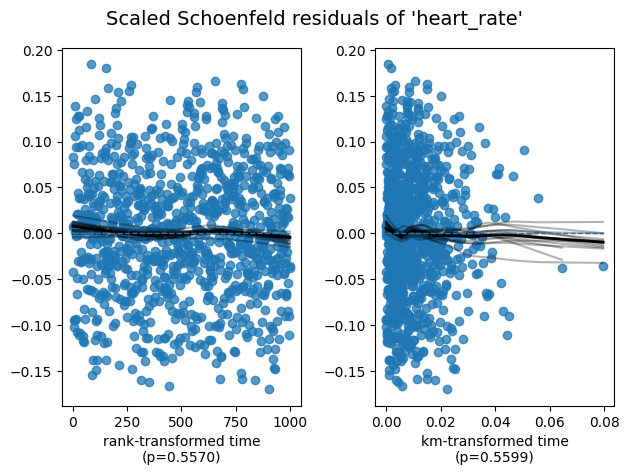

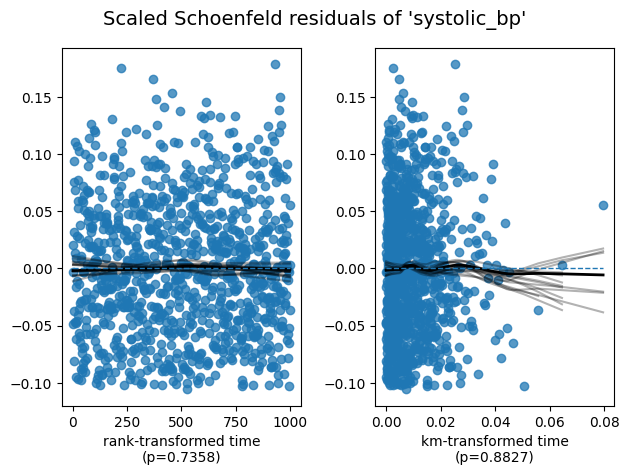

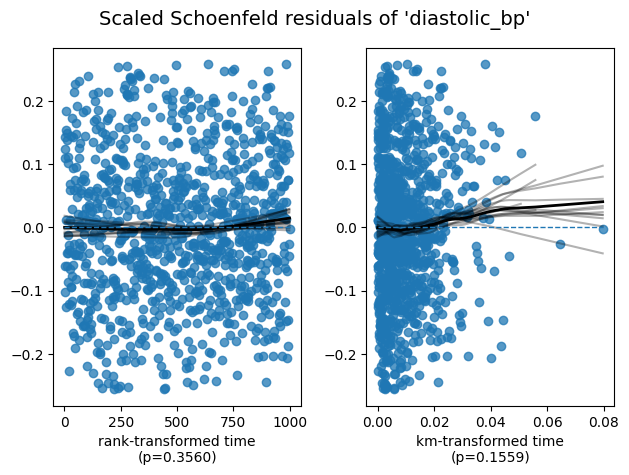

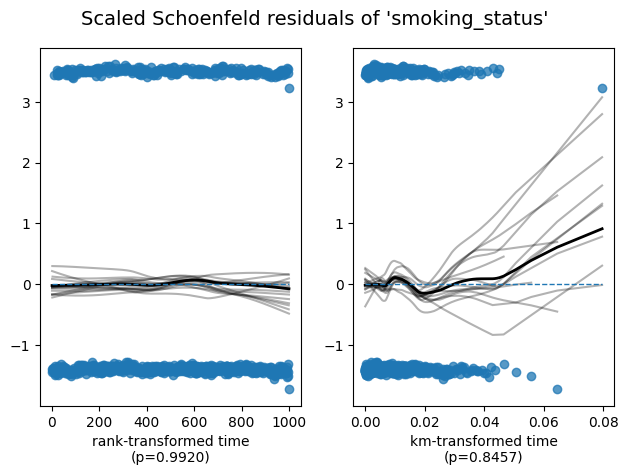

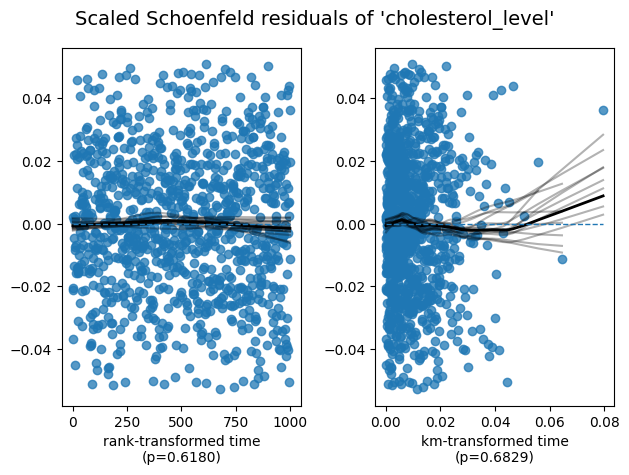

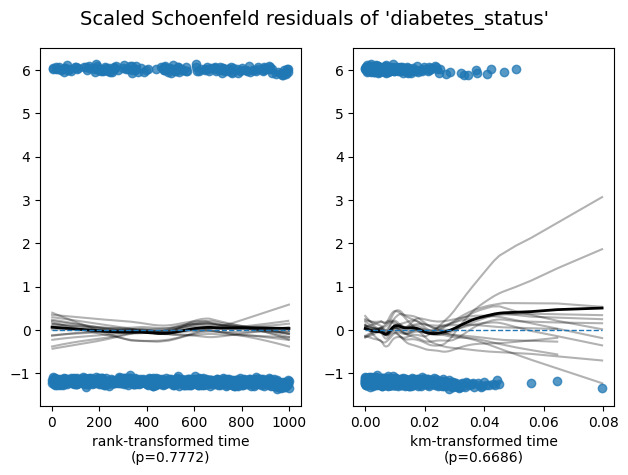

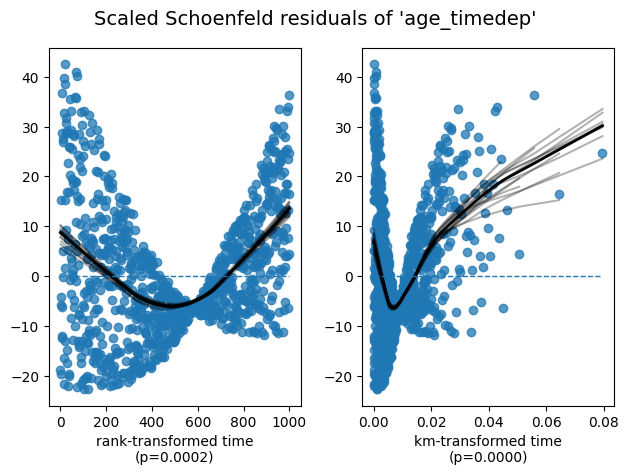

In [42]:
# Check proportional hazards assumption
cph.check_assumptions(data, p_value_threshold=0.05, show_plots=True)

#Risk Group Comparison

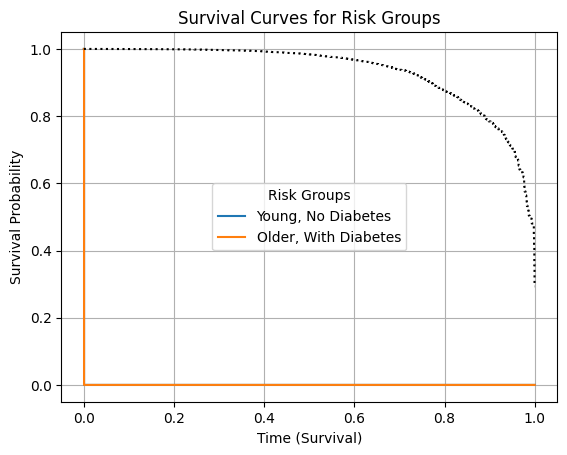

In [44]:
# Define groups based on age and diabetes status
group_1 = {"age_at_heart_attack": 30, "diabetes_status": 0}
group_2 = {"age_at_heart_attack": 60, "diabetes_status": 1}

# Plot survival curves for the two groups
cph.plot_covariate_groups(["age_at_heart_attack", "diabetes_status"],
                          values=[[30, 0], [60, 1]])

# Customise the plot
plt.title('Survival Curves for Risk Groups')
plt.xlabel('Time (Survival)')
plt.ylabel('Survival Probability')
plt.legend(["Young, No Diabetes", "Older, With Diabetes"], title="Risk Groups")
plt.grid(True)
plt.show()

In [47]:
# Create a DataFrame for specific covariates
covariates = pd.DataFrame({
    "age_at_heart_attack": [30, 40, 50, 60],
    "pericardial_effusion": [0.2, 0.2, 0.2, 0.2],
    "fractional_shortening": [0.1, 0.1, 0.1, 0.1],
    "alive_at_one": [1, 1, 1, 1],
    "smoking_status": [0, 0, 0, 0],
    "diabetes_status": [0, 0, 0, 0],
    "age_timedep": [30 * 0.5, 40 * 0.5, 50 * 0.5, 60 * 0.5],
    # Add the missing variables with default or placeholder values
    "left_ventricular_end_diastolic": [4, 4, 4, 4],
    "wall_motion_score": [10, 10, 10, 10],
    "wall_motion_index": [1, 1, 1, 1],
    "mult": [1, 1, 1, 1],
    "ejection_fraction": [55, 55, 55, 55],
    "heart_rate": [70, 70, 70, 70],
    "systolic_bp": [120, 120, 120, 120],
    "diastolic_bp": [80, 80, 80, 80],
    "cholesterol_level": [200, 200, 200, 200]
})

# Generate survival probabilities
survival_prob = cph.predict_survival_function(covariates)
print(survival_prob)

# Save survival probabilities to a CSV file
survival_prob.to_csv("survival_probabilities.csv")

            0    1    2    3
0.000015  1.0  1.0  1.0  1.0
0.000041  1.0  1.0  1.0  1.0
0.000049  1.0  1.0  1.0  1.0
0.000056  1.0  1.0  1.0  1.0
0.000057  1.0  1.0  1.0  1.0
...       ...  ...  ...  ...
0.999938  0.0  0.0  0.0  0.0
0.999946  0.0  0.0  0.0  0.0
0.999968  0.0  0.0  0.0  0.0
0.999978  0.0  0.0  0.0  0.0
1.000000  0.0  0.0  0.0  0.0

[99939 rows x 4 columns]


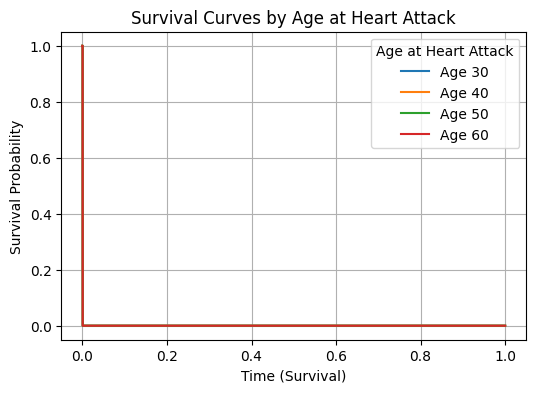

In [51]:
import matplotlib.pyplot as plt

# Create a DataFrame for specific covariates
covariates = pd.DataFrame({
    "age_at_heart_attack": [30, 40, 50, 60],
    "pericardial_effusion": [0.2, 0.2, 0.2, 0.2],
    "fractional_shortening": [0.1, 0.1, 0.1, 0.1],
    "alive_at_one": [1, 1, 1, 1],
    "smoking_status": [0, 0, 0, 0],
    "diabetes_status": [0, 0, 0, 0],
    "age_timedep": [30 * 0.5, 40 * 0.5, 50 * 0.5, 60 * 0.5],
    "left_ventricular_end_diastolic": [4, 4, 4, 4],
    "wall_motion_score": [10, 10, 10, 10],
    "wall_motion_index": [1, 1, 1, 1],
    "mult": [1, 1, 1, 1],
    "ejection_fraction": [55, 55, 55, 55],
    "heart_rate": [70, 70, 70, 70],
    "systolic_bp": [120, 120, 120, 120],
    "diastolic_bp": [80, 80, 80, 80],
    "cholesterol_level": [200, 200, 200, 200]
})

# Generate survival probabilities
survival_prob = cph.predict_survival_function(covariates)

# Plot the survival probabilities
plt.figure(figsize=(6, 4))
for i, col in enumerate(survival_prob.columns):
    plt.plot(survival_prob.index, survival_prob[col], label=f"Age {covariates['age_at_heart_attack'][i]}")

# Customise the plot
plt.title('Survival Curves by Age at Heart Attack')
plt.xlabel('Time (Survival)')
plt.ylabel('Survival Probability')
plt.legend(title="Age at Heart Attack")
plt.grid(True)
plt.show()